In [14]:
import numpy as np

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))


In [15]:
from sklearn.datasets import make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 42

X_train, y_train, X_temp, y_temp, adhoc_total = ad_hoc_data(
    training_size=30,
    test_size=20,
    n=2,
    gap=0.1,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

# # First split: 60% train, 40% temp
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.4, random_state=42, stratify=y
# )

# Second split: 20% validation, 20% test (from the 40% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp
)



print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Train set size: (60, 2)
Validation set size: (20, 2)
Test set size: (20, 2)


In [16]:
# np.savez_compressed(
#     "../data/ad_hoc_data.npz",
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     X_test=X_test,
#     y_test=y_test
# )

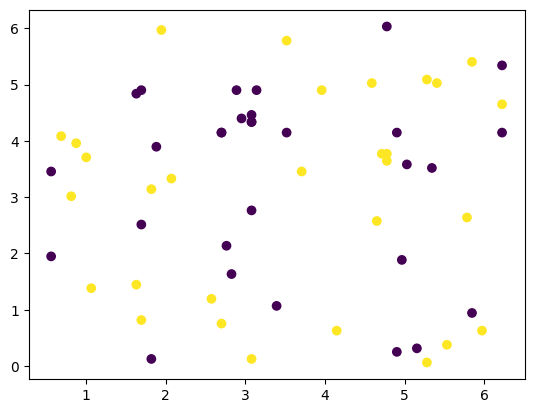

In [17]:
from matplotlib import pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

In [18]:
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
from src.utils import calculate_accuracy, class_similarity, caculate_accuracy_train, caculate_accuracy_train1

rbf_K_train = rbf_kernel(X_train)
rbf_K_val = rbf_kernel(X_val, X_train)
rbf_K_test = rbf_kernel(X_test, X_train)

# classical_val_acc, classical_test_acc, model1 = calculate_accuracy(rbf_K_train, rbf_K_val, rbf_K_test, y_train, y_val, y_test)
train_acc, model, best_c = caculate_accuracy_train(rbf_K_train, y_train)

train_acc1, model1 = caculate_accuracy_train1(rbf_K_train, y_train)
# print("Val acc | Test acc")
# print(f"{classical_val_acc} | {classical_test_acc}")
print(f"Train acc: {train_acc}, Best C = {best_c}")

print(f"Train acc1: {train_acc1}")

sepate = class_similarity(rbf_K_train, y_train)
print(sepate)

Train acc: 1.0, Best C = 58.0
Train acc1: 0.7333333333333333
7.953156356021979


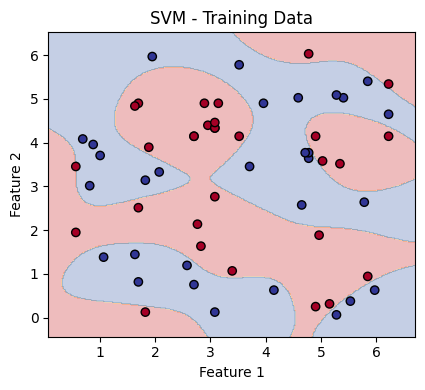

In [19]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import matplotlib.pyplot as plt

# The model is already trained with precomputed kernel
svm = model

# Create mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]
K_mesh = rbf_kernel(mesh_points, X_train)  # Kernel between mesh and training data

# Predict on mesh grid using the precomputed kernel
Z = svm.predict(K_mesh)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 4))

# Training data
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# # Validation data
# plt.subplot(1, 3, 2)
# plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
# plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='RdYlBu', edgecolors='k')
# plt.title(f'SVM - Validation Data\nAcc: {classical_val_acc:.2f}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')

# # Test data
# plt.subplot(1, 3, 3)
# plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k')
# plt.title(f'SVM - Test Data\nAcc: {classical_test_acc:.2f}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [20]:
import importlib

import src.feature_map
importlib.reload(src.feature_map)

<module 'src.feature_map' from 'd:\\QuantumComputing\\SVQSVM1\\src\\feature_map.py'>

In [22]:
from src.feature_map import TrainableQuantumFeatureMap
from src.kernel_estimate import KernelMatrix
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM
import time



# Create optimizer instance based on argument
maxiter = 2000
optimizer_map = {
	"COBYLA": COBYLA(maxiter=maxiter),
	"SPSA": SPSA(maxiter=maxiter),
	"ADAM": ADAM(maxiter=maxiter, lr= 0.1)
}

optimizer = optimizer_map["COBYLA"]

tqfm = TrainableQuantumFeatureMap(depth=8, type_ansatz="RealAmplitudes")

# Train TQFM
start_time = time.time()
tqfm.fit(X_train, y_train, optimizer=optimizer) 
training_time = time.time() - start_time

print(f"Optimal value: {tqfm.optimal_value}")
print(f" Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


# Compute kernel matrices
kernel_train_before = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.init_theta, tqfm.circuit)
kernel_train_after = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.optimal_params, tqfm.circuit)
kernel_val = KernelMatrix.compute_kernel_matrix_with_inner_products(X_val, X_train, tqfm.optimal_params, tqfm.circuit)
kernel_test = KernelMatrix.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm.optimal_params, tqfm.circuit)


Number of qubits: 2, Number of classes: 2
Optimal value: 0.31069482566417683
 Training completed in 455.74 seconds (7.60 minutes)


In [23]:
from src.utils import calculate_accuracy, class_similarity, caculate_accuracy_train, caculate_accuracy_train1
# val_acc_before, test_acc_before, _ = calculate_accuracy(kernel_train_before, kernel_val, kernel_test, y_train, y_val, y_test)
# val_acc_after, test_acc_after, _ = calculate_accuracy(kernel_train_after, kernel_val, kernel_test, y_train, y_val, y_test)

similarity_before = class_similarity(kernel_train_before, y_train)
similarity_after = class_similarity(kernel_train_after, y_train)

train_acc_before, _, best_c_before = caculate_accuracy_train(kernel_train_before, y_train)
train_acc_after, model, best_c_after = caculate_accuracy_train(kernel_train_after, y_train)

train_acc_before1, _, = caculate_accuracy_train1(kernel_train_before, y_train)
train_acc_after1, model1 = caculate_accuracy_train1(kernel_train_after, y_train)



print(f"Class Similarity before TQFM training: {similarity_before:.4f}")
print(f"Class Similarity after TQFM training: {similarity_after:.4f}")
print("="*50)
print(f"Train Accuracy before TQFM training: {train_acc_before:.4f}, best C : {best_c_before}")
print(f"Train Accuracy after TQFM training: {train_acc_after:.4f}, best C : {best_c_after}")
print("="*50)
print(f"Train Accuracy before1 TQFM training: {train_acc_before1:.4f}")
print(f"Train Accuracy after1 TQFM training: {train_acc_after1:.4f}")

# print(f"Val acc: {val_acc_after}")
# print(f"Test acc: {test_acc_after}")

Class Similarity before TQFM training: 3.8982
Class Similarity after TQFM training: 7.2327
Train Accuracy before TQFM training: 0.7000, best C : 2.0
Train Accuracy after TQFM training: 1.0000, best C : 115.0
Train Accuracy before1 TQFM training: 0.6500
Train Accuracy after1 TQFM training: 0.9500


In [24]:
from src.classifier import QuantumClassifier

rhos = tqfm.get_rhos()

qc = QuantumClassifier()
qc.fit(rhos, tqfm.circuit, tqfm.optimal_params)
train_acc_qc = qc.score(X_train, y_train)
print(f"Train Accuracy Quantum Classifier: {train_acc_qc:.4f}")

Train Accuracy Quantum Classifier: 0.9667


In [25]:
ovlA = tqfm.ovlA
ovlB = tqfm.ovlB
cross_ovl = tqfm.cross_ovl
distance = tqfm.distance

print(f"Final Self-overlap Class A: {ovlA[-1]:.4f}")
print(f"Final Self-overlap Class B: {ovlB[-1]:.4f}")
print(f"Final Cross-overlap A-B: {cross_ovl[-1]:.4f}")

Final Self-overlap Class A: 0.3922
Final Self-overlap Class B: 0.3681
Final Cross-overlap A-B: 0.1383


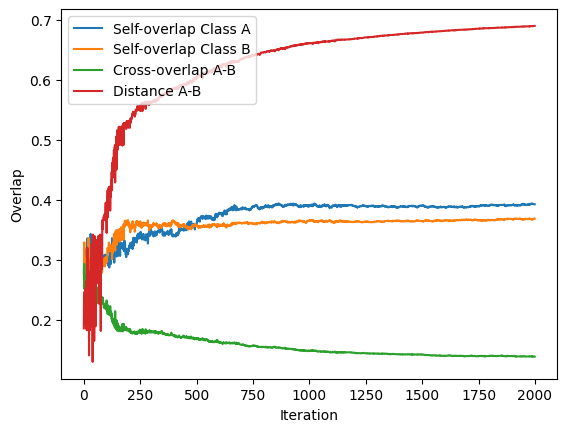

In [26]:
plt.plot(ovlA, label='Self-overlap Class A')
plt.plot(ovlB, label='Self-overlap Class B')
plt.plot(cross_ovl, label='Cross-overlap A-B')
plt.plot(distance, label='Distance A-B')
plt.xlabel('Iteration')
plt.ylabel('Overlap')
plt.legend()
plt.show()

Text(0.5, 1.0, 'TQFM Training Loss History')

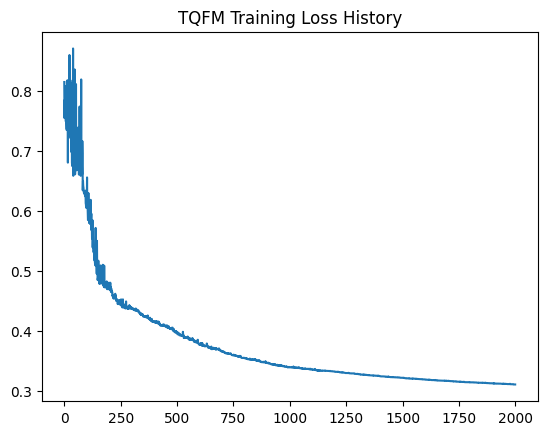

In [27]:
plt.plot(tqfm.loss_history)
plt.title("TQFM Training Loss History")

Computing loss landscape (50x50 grid)...


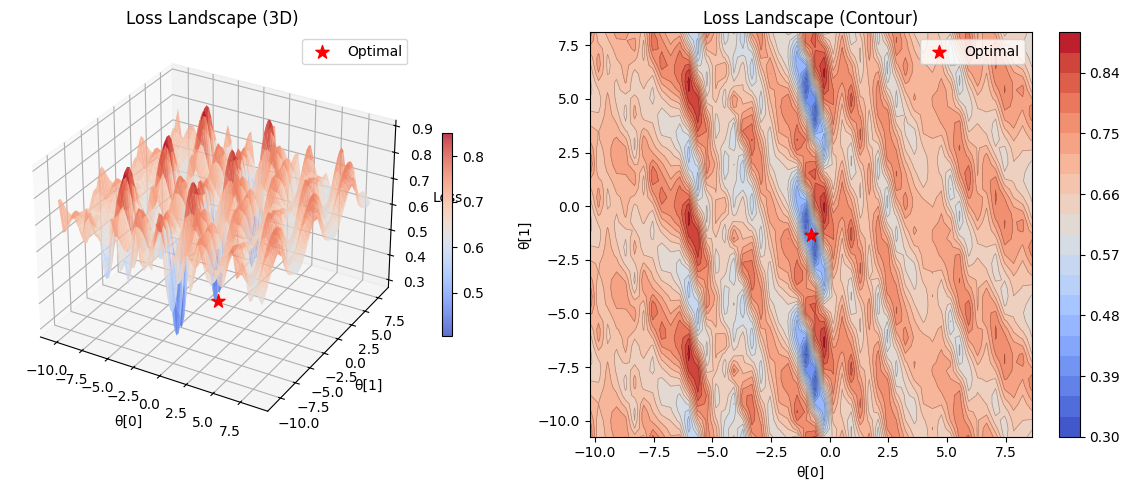

In [28]:
tqfm.plot_loss_landscape(param_idx1=0, param_idx2=1, param_range=3*np.pi, grid_points=50)


Computing loss landscape (100x100 grid)...


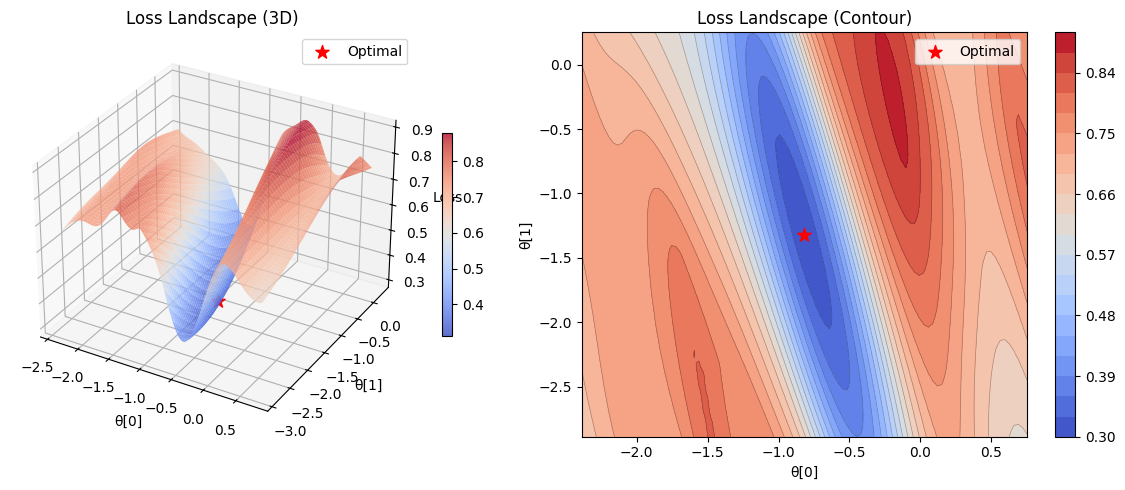

In [30]:
tqfm.plot_loss_landscape(param_idx1=0, param_idx2=1, param_range=0.5*np.pi, grid_points=100)


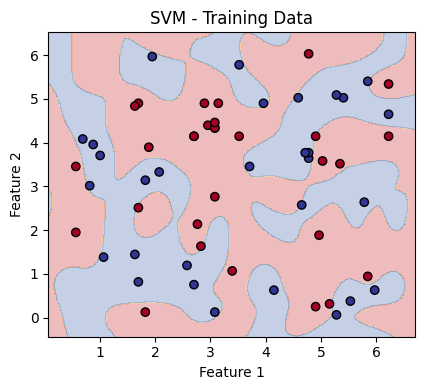

In [29]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# The model is already trained with precomputed kernel
svm = model

# Create mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]
K_mesh = KernelMatrix.compute_kernel_matrix_with_inner_products(mesh_points, X_train, tqfm.optimal_params, tqfm.circuit)

# Predict on mesh grid using the precomputed kernel
Z = svm.predict(K_mesh)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 4))

# Training data
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# # Validation data
# plt.subplot(1, 3, 2)
# plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
# plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='RdYlBu', edgecolors='k')
# plt.title(f'SVM - Validation Data\nAcc: {val_acc_after:.2f}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')

# # Test data
# plt.subplot(1, 3, 3)
# plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k')
# plt.title(f'SVM - Test Data\nAcc: {test_acc_after:.2f}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()